In [107]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st

2) Discrete Event Simulation

**DES code**:

In [108]:
class Queue:
    def __init__(self,env,n_servers,rho,mu,scheduling_type = 'FIFO', service_distribution="M"):
        self.env = env
        self.scheduling_type = scheduling_type
        self.mu = mu
        self.rho = rho
        self.lambd = rho*(n_servers*mu)
        self.cust = 0
        self.arrival_time = 0
        self.service_start_time = 0
        self.service_distribution = service_distribution

        if scheduling_type == 'FIFO':
            self.server = simpy.Resource(env, capacity=n_servers)
        elif scheduling_type == 'SJF':
            self.server = simpy.PriorityResource(env,capacity=n_servers)

    def HyperVariate(self,p, m1, m2):
        rand = np.random.uniform()
        if rand < p:
            return random.expovariate(1.0 / m1)
        else:
            return random.expovariate(1.0 / m2)

    def arrive(self, n_customers,wait_times_list):
        while self.cust < n_customers:
            yield self.env.timeout(random.expovariate(self.lambd))
            self.cust+=1
            self.env.process(self.service(wait_times_list))
    
    def service(self, wait_times_list):
        if self.service_distribution == "M":
            serving_time = random.expovariate(self.mu) 

        elif self.service_distribution == "D":
            serving_time = 1/self.mu
        
        elif self.service_distribution == "H":
            serving_time = self.HyperVariate(0.75, 1, 5)

        else:
            raise ValueError("invalid distribution")

        self.arrival_time = self.env.now

        if self.scheduling_type == 'FIFO':
            with self.server.request() as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)

        elif self.scheduling_type == 'SJF':
            with self.server.request(priority = serving_time) as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)
    
    def run_sim(self, n_customers):
        wait_times_list = []
        self.env.process(self.arrive(n_customers, wait_times_list))
        self.env.run()
        return wait_times_list
        

**Functions:**

In [181]:
def plot_conf_95(waiting_times):
    mean = np.mean(waiting_times)
    
    confidence_interval =st.t.interval(confidence=0.95, df=len(waiting_times)-1, loc=mean, scale=st.sem(waiting_times))
    yerr = np.array([[mean - confidence_interval[0], confidence_interval[1]- mean]])
    return mean, yerr

**Opdracht 2: n=1,2,4**

In [183]:
random.seed(3)
runs = 100
n_customers = 50
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1 = []
wait_total_n2 = []
wait_total_n4 = []

wait_total_n1_sjf = []
wait_total_n2_sjf = []
wait_total_n4_sjf = []
for i in range(runs):
    MM1queue_fifo = Queue(env,1,rho,mu)
    MM2queue_fifo = Queue(env,2,rho,mu)
    MM4queue_fifo = Queue(env,4,rho,mu)
    
    wait_total_n1.extend(MM1queue_fifo.run_sim(n_customers))
    wait_total_n2.extend(MM2queue_fifo.run_sim(n_customers))
    wait_total_n4.extend(MM4queue_fifo.run_sim(n_customers))

    MM1queue_sjf = Queue(env,1,rho,mu, scheduling_type='SJF')
    MM2queue_sjf = Queue(env,2,rho,mu, scheduling_type='SJF')
    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')
    
    wait_total_n1_sjf.extend(MM1queue_sjf.run_sim(n_customers))
    wait_total_n2_sjf.extend(MM2queue_sjf.run_sim(n_customers))
    wait_total_n4_sjf.extend(MM4queue_sjf.run_sim(n_customers))


Code for comparing rho's

In [191]:
# compare for different values of rho
random.seed(3)
runs = 100
n_customers = 50
mu = 1/2

env = simpy.Environment()
rhos_list = np.linspace(0.01,0.99,20)

def waiting_times_of_rhos(rhos_list, servers, runs):
    waiting_times_of_rhos = []
    for rho in rhos_list:
        rho_temp_list = []
        for _ in range(runs):
            MM1queue_rho = Queue(env,servers,rho,mu)
            rho_temp_list.extend(MM1queue_rho.run_sim(n_customers))

        waiting_times_of_rhos.append(rho_temp_list)
    return np.array(waiting_times_of_rhos)

waiting_times_of_rhos_n1 = waiting_times_of_rhos(rhos_list, 1, runs)
waiting_times_of_rhos_n2 = waiting_times_of_rhos(rhos_list, 2, runs)
waiting_times_of_rhos_n4 = waiting_times_of_rhos(rhos_list, 4, runs)


1 server width of final CI: 0.2899812280265106
2 servers width of final CI: 0.15761512727208515


/Users/loesbijman/anaconda3/envs/my-env/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/loesbijman/anaconda3/envs/my-env/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


4 servers width of final CI: 0.06305572662085063


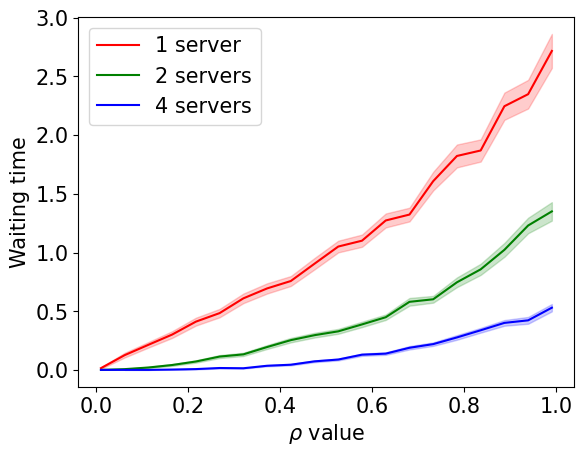

In [201]:
def rho_mean_ci(waiting_times_of_rhos,rhos_list, color, label):
    means = []
    cis = []
    for waiting_times_run in waiting_times_of_rhos:
        mean, yerr = plot_conf_95(waiting_times_run)
        means.append(mean)
        cis.append(yerr)
    plt.plot(rhos_list, means, color = color, label = label)
    plt.fill_between(rhos_list, means - np.array(cis)[:, 0, 0], means + np.array(cis)[:, 0, 1], color = color, alpha = 0.2)
    print(f'{label} width of final CI: {cis[-1][0][0]+cis[-1][0][1]}')

rho_mean_ci(waiting_times_of_rhos_n1, rhos_list, 'red', '1 server')
rho_mean_ci(waiting_times_of_rhos_n2, rhos_list, 'green', '2 servers')
rho_mean_ci(waiting_times_of_rhos_n4, rhos_list, 'blue', '4 servers')
plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)
plt.legend(fontsize=15, loc = 2)
plt.tick_params(labelsize=15)
plt.show()

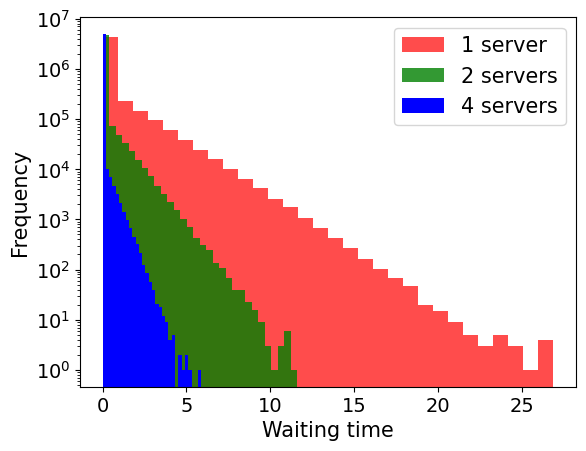

In [169]:
plt.hist(waiting_times_of_rhos_n1[0], bins=30, color = 'red', label = '1 server', alpha = 0.7)
plt.hist(waiting_times_of_rhos_n2[0], bins=30, color = 'green', label = '2 servers', alpha = 0.8)
plt.hist(waiting_times_of_rhos_n4[0], bins=30, color = 'blue', label = '4 servers')
plt.legend(fontsize = 15)
plt.tick_params(labelsize=14)
plt.xlabel('Waiting time', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.yscale('log')
plt.show()

Statistical analysis

In [ ]:
import scipy.stats as stat

# Mann-Whitney U test to test difference between numbers of servers
print(f'begin n = 1 with n = 2: {stat.mannwhitneyu(waiting_times_of_rhos_n1[0],waiting_times_of_rhos_n2[0])}')
print(f'begin n = 1 with n = 4: {stat.mannwhitneyu(waiting_times_of_rhos_n1[0],waiting_times_of_rhos_n4[0])}')
print(f'begin n = 2 with n = 4: {stat.mannwhitneyu(waiting_times_of_rhos_n2[0],waiting_times_of_rhos_n4[0])}')

print(f'end n = 1 with n = 2: {stat.mannwhitneyu(waiting_times_of_rhos_n1[-1],waiting_times_of_rhos_n2[-1])}')
print(f'end n = 1 with n = 4: {stat.mannwhitneyu(waiting_times_of_rhos_n1[-1],waiting_times_of_rhos_n4[-1])}')
print(f'end n = 2 with n = 4: {stat.mannwhitneyu(waiting_times_of_rhos_n2[-1],waiting_times_of_rhos_n4[-1])}')

begin n = 1 with n = 2: MannwhitneyuResult(statistic=14223777792514.5, pvalue=0.0)
begin n = 1 with n = 4: MannwhitneyuResult(statistic=14891408338481.0, pvalue=0.0)
begin n = e with n = 4: MannwhitneyuResult(statistic=13211106861331.5, pvalue=0.0)
end n = 1 with n = 2: MannwhitneyuResult(statistic=16229002018264.0, pvalue=0.0)
end n = 1 with n = 4: MannwhitneyuResult(statistic=19161866482892.0, pvalue=0.0)
end n = 2 with n = 4: MannwhitneyuResult(statistic=16103150930188.0, pvalue=0.0)


In [144]:
# Wilcoxon signed rank test to test difference for n = 1 with low rho and high rho

print(f"n = 1: {stat.wilcoxon(waiting_times_of_rhos_n1[0], waiting_times_of_rhos_n1[1])}")
print(f"n = 2: {stat.wilcoxon(waiting_times_of_rhos_n2[0], waiting_times_of_rhos_n2[1])}")
print(f"n = 4: {stat.wilcoxon(waiting_times_of_rhos_n4[0], waiting_times_of_rhos_n4[1])}")

n = 1: WilcoxonResult(statistic=912562203554.0, pvalue=0.0)
n = 2: WilcoxonResult(statistic=141364121122.0, pvalue=0.0)
n = 4: WilcoxonResult(statistic=4603352935.5, pvalue=0.0)


**3D plot for rho and number of runs**

In [175]:
def ci_runs_rhos(rhos_list, runs_list, servers):
    ci_width_matrix = np.zeros(shape = (len(runs_list),len(rhos_list)))
    for run_index, runs in enumerate(runs_list):
        print('run',runs)
        wait_times_per_rho = waiting_times_of_rhos(rhos_list, servers, runs)
        for rho_index, waiting_times_of_rho in enumerate(wait_times_per_rho):
            _, yerr = plot_conf_95(waiting_times_of_rho)
            width_ci = yerr[0][1]-yerr[0][0]
            ci_width_matrix[run_index, rho_index] = width_ci
    return ci_width_matrix

rhos_list = np.linspace(0.2,0.99,17)
runs_list = range(10,1001,30)
random.seed(3)

ci_width = ci_runs_rhos(rhos_list, runs_list, 2)

run 10
run 40
run 70
run 100
run 130
run 160
run 190
run 220
run 250
run 280
run 310
run 340
run 370
run 400
run 430
run 460
run 490
run 520
run 550
run 580
run 610
run 640
run 670
run 700
run 730
run 760
run 790
run 820
run 850
run 880
run 910
run 940
run 970
run 1000


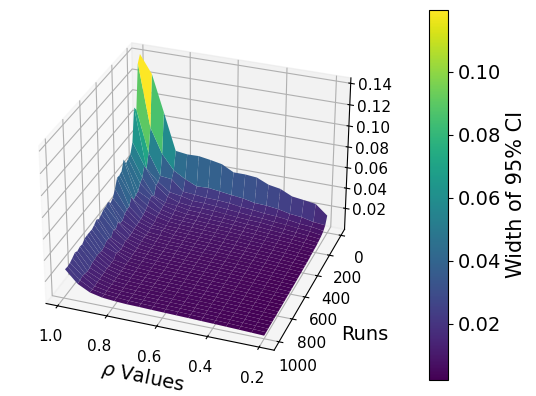

In [176]:
from mpl_toolkits.mplot3d import Axes3D

grid = np.meshgrid(rhos_list, runs_list)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(grid[0], grid[1], ci_width, cmap='viridis')

ax.set_xlabel('$\\rho$ Values', fontsize = 14)
ax.set_ylabel('Runs', fontsize = 14, labelpad=13)
# ax.set_zlabel('Standard Deviation')

ax.view_init(azim = 110)

colorbar = fig.colorbar(surface, ax=ax, pad=0.1)
colorbar.set_label('Width of 95% CI', size=15)
colorbar.ax.tick_params(labelsize=14)

ax.tick_params(labelsize=11)

plt.show()


**Question 3: compare FIFO and SJF**

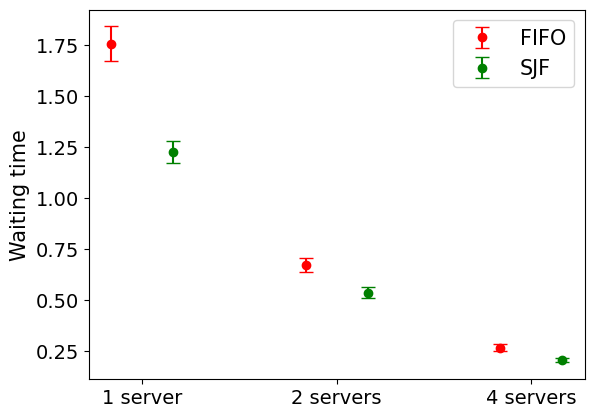

In [184]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='FIFO', color = 'red')
plt.errorbar(x=1+0.16, y=m1_sjf, yerr=yerr1_sjf.T, fmt='o', capsize=5, label='SJF', color = 'green')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2+0.16, y=m2_sjf, yerr=yerr2_sjf.T, fmt='o', capsize=5,color = 'green')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3+0.16, y=m4_sjf, yerr=yerr4_sjf.T, fmt='o', capsize=5,color = 'green')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'], fontsize = 15)
plt.ylabel('Waiting time', fontsize = 15)
plt.tick_params(labelsize = 14)
plt.legend(fontsize = 15)
plt.show()

In [173]:
print(f"For a queue with in total {n_customers} people that get in the queue with system load {rho} for {runs} days:")
print(f"the mean waiting time was {m1}, with a standard deviation of {yerr1}")
print(f"the mean waiting time was {m2}, with a standard deviation of {yerr2}")
print(f"the mean waiting time was {m4}, with a standard deviation of {yerr4}")

print(f"the mean waiting time sjf was {m1_sjf}, with a standard deviation of {yerr1_sjf}")
print(f"the mean waiting time sjf was {m2_sjf}, with a standard deviation of {yerr2_sjf}")
print(f"the mean waiting time sjf was {m4_sjf}, with a standard deviation of {yerr4_sjf}")


For a queue with in total 500 people that get in the queue with system load 0.8 for 10000 days:
the mean waiting time was 1.6377590520500607, with a standard deviation of [[1.63148498 1.64403313]]
the mean waiting time was 0.7273675987929226, with a standard deviation of [[0.72433906 0.73039613]]
the mean waiting time was 0.2989505460756179, with a standard deviation of [[0.29754534 0.30035575]]
the mean waiting time sjf was 1.318021046582416, with a standard deviation of [[1.31353518 1.32250692]]
the mean waiting time sjf was 0.6048065647156785, with a standard deviation of [[0.60253998 0.60707315]]
the mean waiting time sjf was 0.25602494178487456, with a standard deviation of [[0.25491017 0.25713971]]


opdracht 3: plot waiting times against number of customers with 4 servers

In [ ]:
random.seed(3)
runs = 10
n_customers = 5
rho = 0.8
mu = 1/2

env = simpy.Environment()


waiting_times = []

waiting_times_sjf = []
for i in range(runs):
    MM4queue_fifo = Queue(env,4,rho,mu)

    waiting_times.append(MM4queue_fifo.run_sim(n_customers))

    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')

    waiting_times_sjf.append(MM4queue_sjf.run_sim(n_customers))

**Opdracht 4**

In [179]:
random.seed(3)
runs = 200
n_customers = 50
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1_Det = []
wait_total_n2_Det = []
wait_total_n4_Det = []

wait_total_n1_Hexp = []
wait_total_n2_Hexp = []
wait_total_n4_Hexp = []


for i in range(runs):
    MD1queue_fifo = Queue(env,1,rho,mu, service_distribution="D")
    MD2queue_fifo = Queue(env,2,rho,mu, service_distribution="D")
    MD4queue_fifo = Queue(env,4,rho,mu, service_distribution="D")
    
    wait_total_n1_Det.extend(MD1queue_fifo.run_sim(n_customers))
    wait_total_n2_Det.extend(MD2queue_fifo.run_sim(n_customers))
    wait_total_n4_Det.extend(MD4queue_fifo.run_sim(n_customers))

    MH1queue_fifo = Queue(env,1,rho,mu, service_distribution="H")
    MH2queue_fifo = Queue(env,2,rho,mu, service_distribution="H")
    MH4queue_fifo = Queue(env,4,rho,mu, service_distribution="H")
    
    wait_total_n1_Hexp.extend(MH1queue_fifo.run_sim(n_customers))
    wait_total_n2_Hexp.extend(MH2queue_fifo.run_sim(n_customers))
    wait_total_n4_Hexp.extend(MH4queue_fifo.run_sim(n_customers))




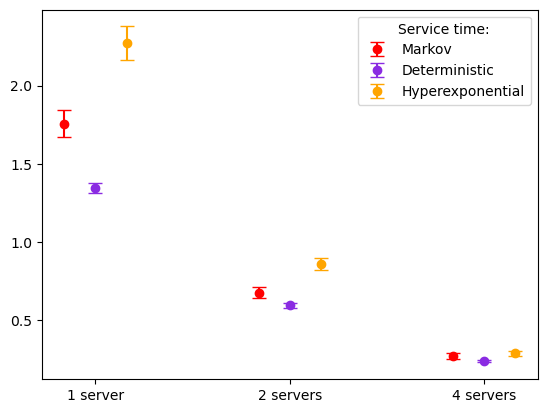

In [185]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

m1_Det, yerr1_Det = plot_conf_95(wait_total_n1_Det)
m2_Det, yerr2_Det = plot_conf_95(wait_total_n2_Det)
m4_Det, yerr4_Det = plot_conf_95(wait_total_n4_Det)

m1_Hexp, yerr1_Hexp = plot_conf_95(wait_total_n1_Hexp)
m2_Hexp, yerr2_Hexp = plot_conf_95(wait_total_n2_Hexp)
m4_Hexp, yerr4_Hexp = plot_conf_95(wait_total_n4_Hexp)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='Markov', color = 'red')
plt.errorbar(x=1, y=m1_Det, yerr=yerr1_Det.T, fmt='o', capsize=5, label='Deterministic', color = 'blueviolet')
plt.errorbar(x=1+0.16, y=m1_Hexp, yerr=yerr1_Hexp.T, fmt='o', capsize=5, label='Hyperexponential', color = 'orange')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2, y=m2_Det, yerr=yerr2_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=2+0.16, y=m2_Hexp, yerr=yerr2_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3, y=m4_Det, yerr=yerr4_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=3+0.16, y=m4_Hexp, yerr=yerr4_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'])
plt.legend(title="Service time:")
plt.show()